In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [36]:
train_data, test_data = pd.read_csv('train.csv'), pd.read_csv('test.csv')

In [37]:
train_data.drop(train_data[train_data['made']==10000].index, inplace=True)
train_data.drop(train_data[train_data['floors']==6000].index, inplace=True)
train_data.drop(train_data[train_data['garage']>1000].index, inplace=True)
train_data.drop(train_data[train_data['squareMeters']>100000].index, inplace=True)
train_data.drop(train_data[train_data['basement']>10000].index, inplace=True)
train_data.drop(train_data[train_data['attic']>10000].index, inplace=True)

In [38]:
train_data['age'] = 2022-train_data['made']
train_data.drop('made', axis=1, inplace=True)

test_data['age'] = 2022-test_data['made']
test_data.drop('made', axis=1, inplace=True)

In [39]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(train_data['squareMeters'].values.reshape(-1,1), train_data['price'].values)

m = linreg.coef_
c = linreg.intercept_

xline = range(100000)
yline = (m*xline) + c

In [40]:
train_data['distance'] = abs((m*train_data['squareMeters'])-train_data['price']+c)/math.sqrt((m**2)+1)

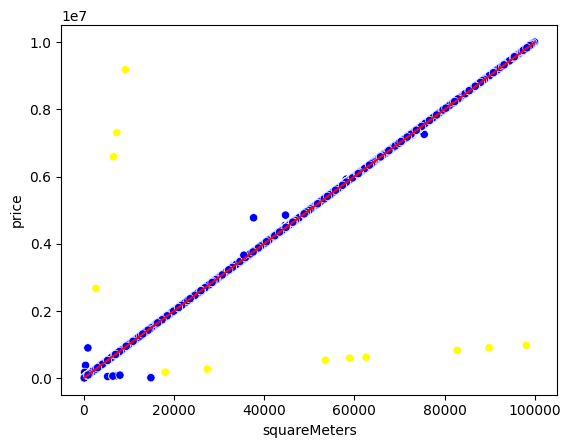

In [42]:
sns.scatterplot(data=train_data, x='squareMeters', y='price', 
                c=['blue' if x else 'yellow' for x in train_data['distance']<15000])
plt.plot(xline,yline,c='red')

In [20]:
train_data.drop(train_data[train_data['distance']>10000].index, inplace=True)
train_data.drop('distance', axis=1, inplace=True)

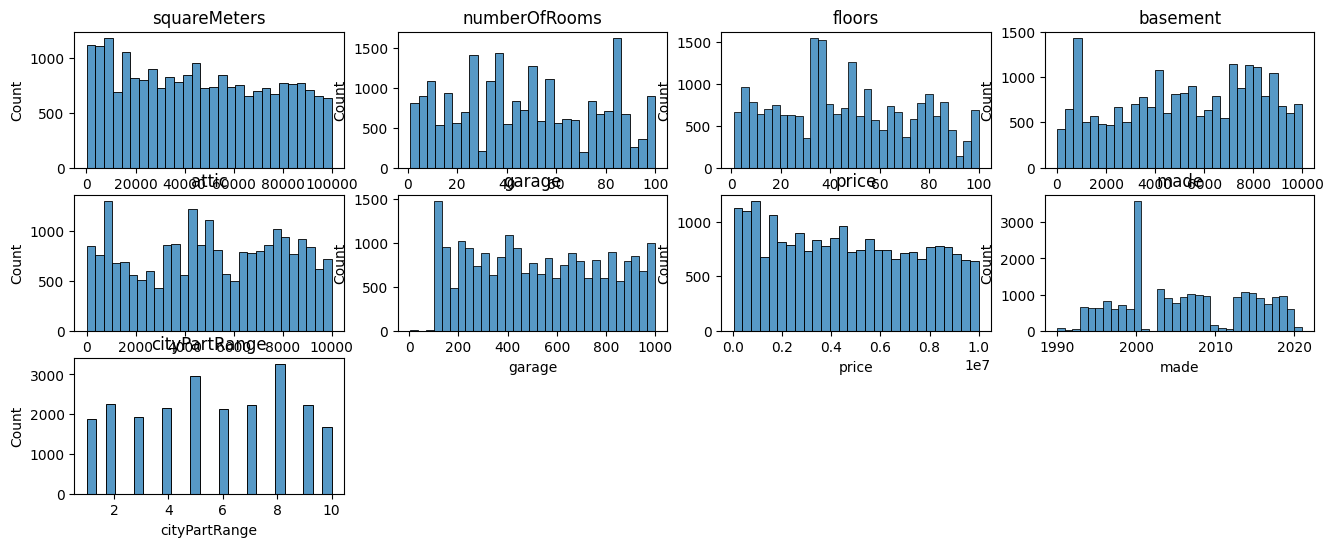

In [15]:
plt.figure(figsize=(16,6))
columns = ['squareMeters','numberOfRooms','floors','basement','attic','garage','price','made','cityPartRange']
for i in range(len(columns)):
    ax = plt.subplot(3,4,i+1)
    ax.set_title(columns[i])
    sns.histplot(train_data[columns[i]])

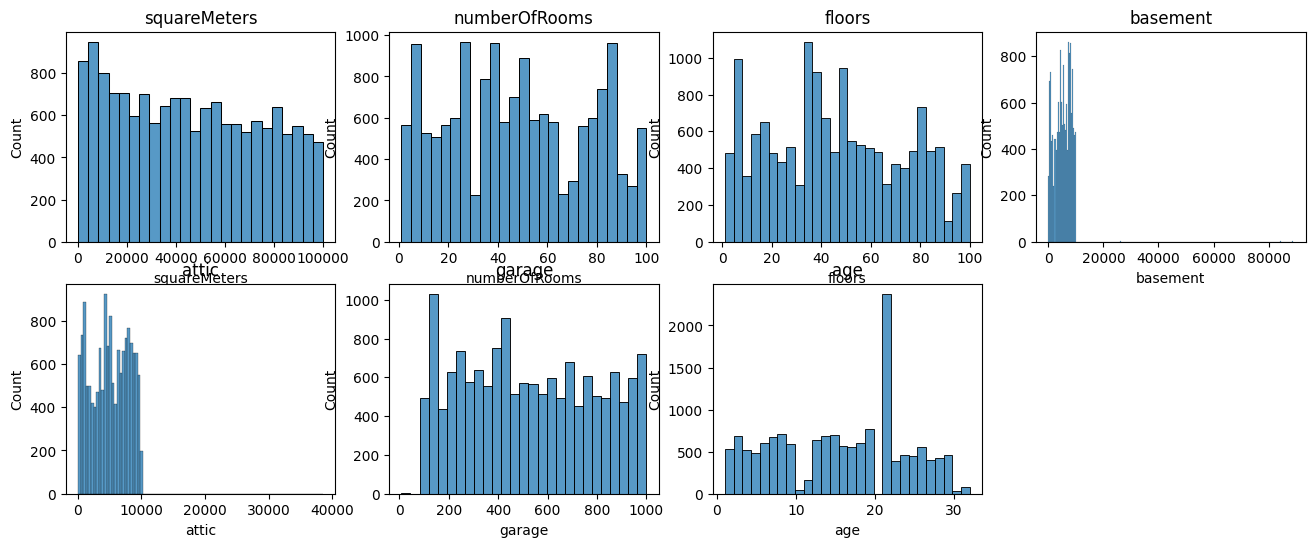

In [55]:
plt.figure(figsize=(16,6))
columns = ['squareMeters','numberOfRooms','floors','basement','attic','garage','age']
for i in range(len(columns)):
    ax = plt.subplot(2,4,i+1)
    ax.set_title(columns[i])
    sns.histplot(test_data[columns[i]])

In [21]:
y = train_data['price']
x = train_data.drop(['price','id','cityCode'], axis=1)
x_test = test_data.drop(['id','cityCode'], axis=1)

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [23]:
target_scaler = MinMaxScaler()
y = pd.DataFrame(target_scaler.fit_transform(y.values.reshape(-1,1)),columns=['price'],index=train_data.index)

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.1,random_state=42)

## Nueral Network

In [25]:
x_train.shape

(20414, 15)

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(units=15, activation='relu', input_shape=[15]),
    layers.Dense(units=30, activation='relu'),
    layers.Dense(units=1)
])

In [27]:
model.compile(optimizer='Adam', loss="mean_squared_error")
early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=0.0001, restore_best_weights=True)

In [28]:
history = model.fit(
    x_train,y_train,
    validation_data=(x_val,y_val),
    epochs=500,
    batch_size=1000,
    callbacks=early_stopping
)

Epoch 1/500
21/21 [==============================] - 2s 23ms/step - loss: 0.1177 - val_loss: 0.0863
Epoch 2/500
21/21 [==============================] - 0s 4ms/step - loss: 0.0750 - val_loss: 0.0636
Epoch 3/500
21/21 [==============================] - 0s 5ms/step - loss: 0.0562 - val_loss: 0.0478
Epoch 4/500
21/21 [==============================] - 0s 9ms/step - loss: 0.0409 - val_loss: 0.0333
Epoch 5/500
21/21 [==============================] - 0s 9ms/step - loss: 0.0265 - val_loss: 0.0201
Epoch 6/500
21/21 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0103
Epoch 7/500
21/21 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 8/500
21/21 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 9/500
21/21 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 10/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11

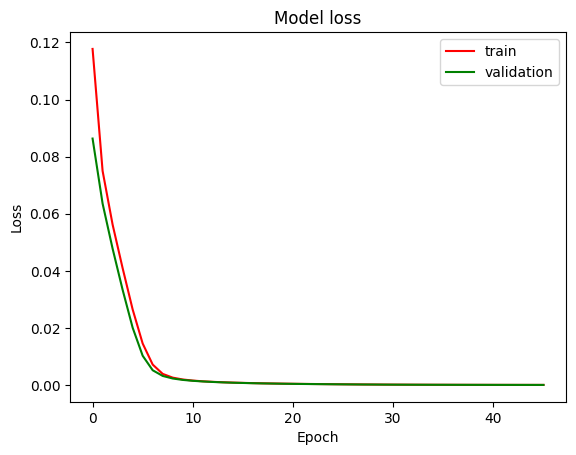

In [29]:
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [30]:
result = model.predict(x_test)

474/474 [==============================] - 1s 1ms/step


In [31]:
new_result = target_scaler.inverse_transform(result)

In [32]:
new_result = new_result.reshape(1,-1)[0]

<AxesSubplot: ylabel='Count'>

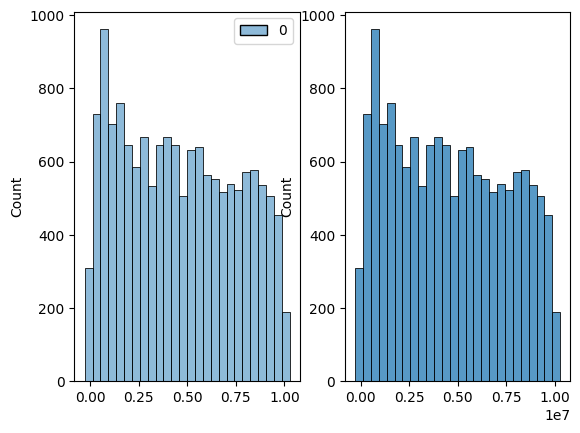

In [33]:
plt.subplot(1,2,1)
sns.histplot(result)
plt.subplot(1,2,2)
sns.histplot(new_result)

In [34]:
df = pd.DataFrame({'id':test_data['id'].values, 'price':new_result})
df.to_csv('submission.csv', index=False)